<a href="https://colab.research.google.com/github/AURORARISE/MSSP-6070/blob/main/week11_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install geopandas folium shapely fiona pyproj --quiet
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import re
import folium

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
cong_path = "/content/drive/MyDrive/MSSP6070/c. Modules/Week_11/california-congressional-districts.geojson"
leg_pop_path = "/content/drive/MyDrive/MSSP6070/c. Modules/Week_11/CA_Legislative_Districts.csv"

In [38]:
cong_gdf = gpd.read_file(cong_path)
print("Congressional file columns:", cong_gdf.columns)

Congressional file columns: Index(['Name', 'description', 'descriptio', 'geometry'], dtype='object')


In [39]:
leg_df = pd.read_csv(leg_pop_path)
print("Legislative csv columns:", leg_df.columns)

Legislative csv columns: Index(['OBJECTID', 'ID', 'AREA', 'DISTRICT', 'MEMBERS', 'NAME', 'POPULATION',
       'CVAP_19', 'HSP_CVAP_1', 'DOJ_NH_BLK', 'DOJ_NH_ASN', 'NH_WHT_CVA',
       'IDEAL_VALU', 'DEVIATION', 'F_DEVIATIO', 'MULTIPLE_F', 'F_CVAP_19',
       'F_HSP_CVAP', 'F_DOJ_NH_B', 'F_DOJ_NH_A', 'F_NH_WHT_C', 'DISTRICT_L',
       'DISTRICT_N', 'SHAPE_Length', 'SHAPE_Area'],
      dtype='object')


In [40]:
if "Name" in cong_gdf.columns:
  cong_gdf["DISTRICT"] = cong_gdf["Name"].str.extract(r"(\d+)").astype(float).astype("Int64")
else:
  raise ValueError("Can't find 'Name' column in congressional geojson. Please adjust the code to use the correct column.")

In [41]:
if "DISTRICT" not in leg_df.columns:
  raise ValueError("CSV does not contain 'DISTRICT' column. Please check the column name.")

In [42]:
pop_col_candidates = ["POPULATION", "Population", "POP", "TOTAL_POP", "Tot_Pop"]
pop_col = None
for c in pop_col_candidates:
    if c in leg_df.columns:
        pop_col = c
        break

if pop_col is None:
    raise ValueError("Cannot find a population column. Please check the CSV and set pop_col manually.")

print(f"Using '{pop_col}' as population column.")

Using 'POPULATION' as population column.


In [43]:
pop_df = leg_df[["DISTRICT", pop_col]].drop_duplicates()
pop_df = pop_df.rename(columns={pop_col: "POPULATION"})
print(pop_df.head())

   DISTRICT  POPULATION
0         1      760066
1        10      760066
2        11      760067
3        12      760065
4        13      760065


In [44]:
cong_merged = cong_gdf.merge(pop_df, on="DISTRICT", how="left")

print("Merged columns:", cong_merged.columns)
print("Number of districts with population matched:", cong_merged["POPULATION"].notna().sum())

Merged columns: Index(['Name', 'description', 'descriptio', 'geometry', 'DISTRICT',
       'POPULATION'],
      dtype='object')
Number of districts with population matched: 52


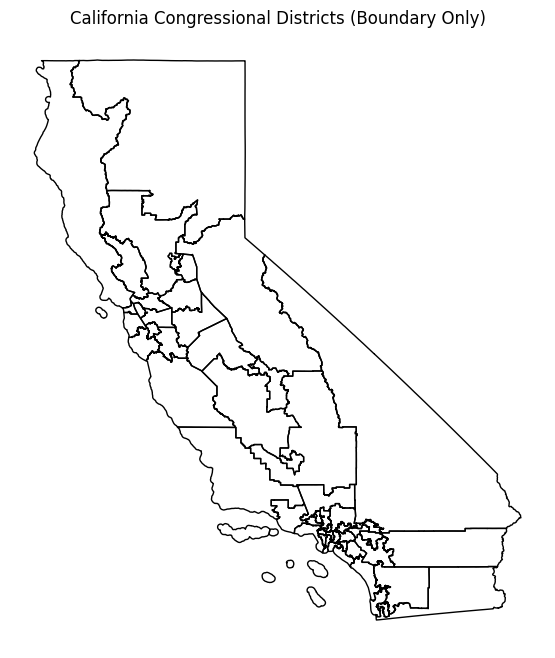

In [45]:
fig, ax = plt.subplots(figsize=(8, 8))
cong_gdf.plot(ax=ax, edgecolor="black", facecolor="none")
ax.set_title("California Congressional Districts (Boundary Only)")
ax.set_axis_off()
plt.show()

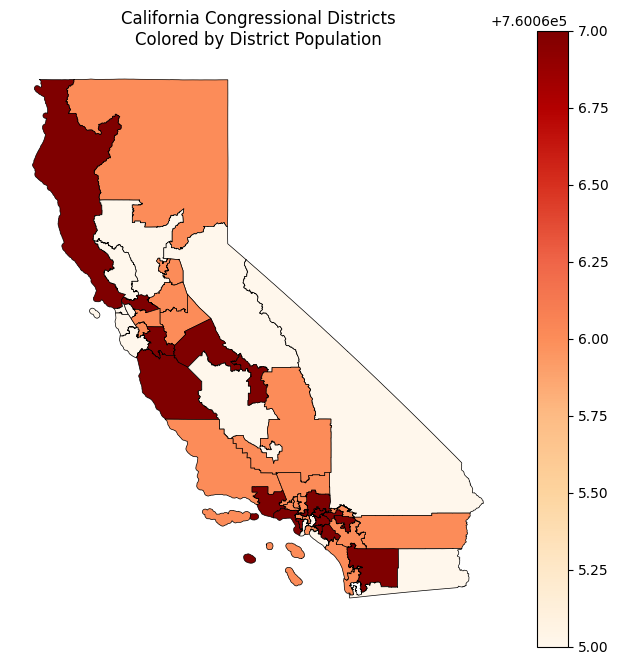

In [46]:
fig, ax = plt.subplots(figsize=(8, 8))

cong_merged.plot(
    column="POPULATION",
    cmap="OrRd",
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    ax=ax
)

ax.set_title("California Congressional Districts\nColored by District Population")
ax.set_axis_off()
plt.show()

/tmp/ipython-input-2356116636.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cong_merged["centroid"] = cong_merged.geometry.centroid


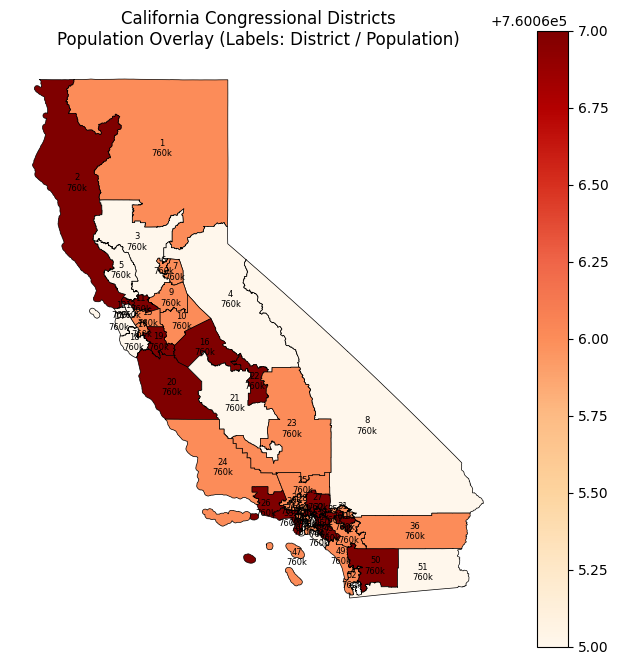

In [47]:
cong_merged["centroid"] = cong_merged.geometry.centroid

fig, ax = plt.subplots(figsize=(8, 8))
cong_merged.plot(
    column="POPULATION",
    cmap="OrRd",
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    ax=ax
)

for _, row in cong_merged.dropna(subset=["POPULATION"]).iterrows():
  x = row["centroid"].x
  y = row["centroid"].y
  label = f"{int(row['DISTRICT'])}\n{int(row['POPULATION'])//1000}k"
  ax.text(x, y, label, fontsize=6, ha="center", va="center")

ax.set_title("California Congressional Districts\nPopulation Overlay (Labels: District / Population)")
ax.set_axis_off()
plt.show()

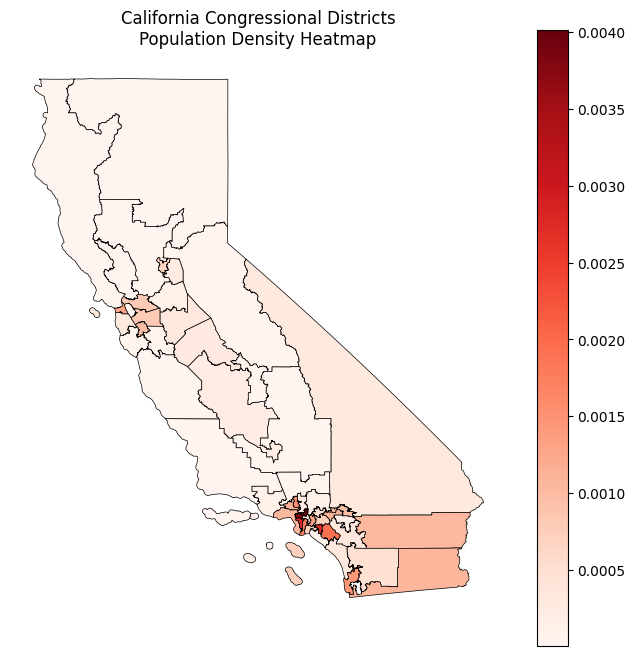

In [48]:
density_col = None
for c in ["SHAPE_Area", "AREA", "Shape_Area"]:
    if c in leg_df.columns:
        density_col = c
        break

if density_col is not None:
    density_df = leg_df[["DISTRICT", "POPULATION", density_col]].copy()
    density_df["POP_DENSITY"] = density_df["POPULATION"] / density_df[density_col]
    cong_merged = cong_merged.drop(columns=[c for c in ["POP_DENSITY"] if c in cong_merged.columns])
    cong_merged = cong_merged.merge(
        density_df[["DISTRICT", "POP_DENSITY"]],
        on="DISTRICT", how="left"
    )
    heat_col = "POP_DENSITY"
    title = "California Congressional Districts\nPopulation Density Heatmap"
else:
    heat_col = "POPULATION"
    title = "California Congressional Districts\nPopulation Heatmap"

fig, ax = plt.subplots(figsize=(8, 8))
cong_merged.plot(
    column=heat_col,
    cmap="Reds",
    linewidth=0.5,
    edgecolor="black",
    legend=True,
    ax=ax
)
ax.set_title(title)
ax.set_axis_off()
plt.show()

In [49]:
cong_wgs84 = cong_merged.to_crs(epsg=4326)
cong_for_folium = cong_wgs84.drop(columns=["centroid"], errors="ignore")
center = cong_for_folium.geometry.unary_union.centroid
center_lat, center_lon = center.y, center.x

m = folium.Map(location=[center_lat, center_lon], zoom_start=6, tiles="cartodbpositron")

/tmp/ipython-input-3573864895.py:3: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  center = cong_for_folium.geometry.unary_union.centroid


In [50]:
folium.Choropleth(
    geo_data=cong_for_folium,
    data=cong_for_folium,
    columns=["DISTRICT", heat_col],
    key_on="feature.properties.DISTRICT",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.4,
    legend_name=heat_col
).add_to(m)

In [52]:
folium.GeoJson(
    cong_for_folium,
    name="Congressional Districts",
    tooltip=folium.GeoJsonTooltip(
        fields=["DISTRICT", "POPULATION"],
        aliases=["District", "Population"],
    ),
).add_to(m)
m